In [3]:
'''
This notebook applies qiskit built-in quantum inspired classification to real-wold data.

Data Source:
"Electrical Grid Stability Simulated Data Data Set"
https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+

Reference:  
'Towards Concise Models of Grid Stability.' 
Communications, Control, and Computing Technologies for Smart Grids (SmartGridComm), 
2018 IEEE International Conference on. IEEE, 2018 

'''

'''
# Some epxerimental results from running this notebook on IBM Quantum Lab 
# train/test = 300/100 
# random_state=0

# feature normalize accuracy, kernel  
# 12      no        77%     linear
# 12      no        80%     rbf 
# 12      no        65%     quantum      (depth=2, no difference with 3 or 4) 
# kpca-2  no        65%     QVC-SPSA-2   (2 qubits, about 20 minutes on ibmq_qasm_simulator)
# kpca-6  no        65%     QVC-SPSA-6   (6 qubits, about 40 minutes on ibmq_qasm_simulator)
# vae-z-2 no        57%     QVC-SPSA-2

# 12      yes       77%     linear
# 12      yes       80%     rbf 
# 12      yes       65%     quantum      (up to 4 minutes for computing quantum kernel)
# kpca-2  yes       56%     QVC-SPSA     (interesting that normalization hurts)

kpca: kernal PCA
vae: variational autoencoder

'''

### experiment config
normalizeFeature=False
toViz=True
seed=0
feature_dimensions=12
reduced_dimensions=2
subtrainset=300 # Full data set too huge for QML
subtestset=100

In [2]:
import numpy as np
import pandas as pd

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import * #QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# Check backends' availability
backends = IBMQ.providers()[0].backends()
print('{:<10} {:<14} {}'.format('Available', 'pending_jobs', 'name'))
for backend in backends:
    status = backend.status()
    print('{:<10} {:<14} {}'.format('True' if status.operational==1 else 'False',
                                    status.pending_jobs, backend.name()))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Available  pending_jobs   name
True       0              ibmq_qasm_simulator
True       548            ibmq_lima
True       81             ibmq_belem
True       60             ibmq_quito
True       0              simulator_statevector
True       0              simulator_mps
True       0              simulator_extended_stabilizer
True       0              simulator_stabilizer
True       117            ibmq_manila
True       294            ibm_nairobi
True       110            ibm_oslo


In [4]:
## prepare training and test sets
from sklearn import preprocessing
import random
import time
random.seed(0)

# load data file
df=pd.read_csv("data/dataset.egss", header=0)
X=df[["tau1","tau2","tau3","tau4","p1","p2","p3","p4","g1","g2","g3","g4"]]
y=df["stabf"]

# take random 80% for training, rest for test.
indice=np.arange(len(y))
split_idx=int(len(indice)*0.8)
random.shuffle(indice)

train_labels=[0 if y.iloc[i]=='stable' else 1 for i in indice[:split_idx]]
test_labels=[0 if y.iloc[i]=='stable' else 1 for i in indice[split_idx:]]
feature_dimensions=len(X.iloc[0])

if normalizeFeature:
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    X_norm = pd.DataFrame(min_max_scaler.fit_transform(X))
    train_data=[X_norm.iloc[i] for i in indice[:split_idx]]
    test_data=[X_norm.iloc[i] for i in indice[split_idx:]]
else:
    train_data=[X.iloc[i] for i in indice[:split_idx]]
    test_data=[X.iloc[i] for i in indice[split_idx:]]

print("Binary classifiers with Support Vector Machine.\n")
    
print("Data set: Electrical Grid Stability Simulated Data")
print(f"{len(indice)} input data points. Input feature dimensions {feature_dimensions}.")


## train SVCs with Linear and RBF kernels
from sklearn.svm import SVC    
    
print(f"Normalize input feature: {normalizeFeature}\n")
print(f"Entire data set : {len(train_labels)} (training) and {len(test_labels)} (testing)")

model = SVC(kernel='linear', random_state=seed, probability=True)
model.fit(train_data, train_labels)
accuracy_linear = model.score(test_data, test_labels)
print("Linear kernel - Test accuracy = {:<4.1f}%".format(accuracy_linear*100))

model = SVC(kernel='rbf', random_state=seed, probability=True)
model.fit(train_data, train_labels)
accuracy_rbf = model.score(test_data, test_labels)
print("RBF kernel - Test accuracy = {:<4.1f}%\n\n".format(accuracy_rbf*100))


if subtrainset<len(train_labels):
    print(f"Take {subtrainset} (training) and {subtestset} (testing) ",
          "for performance comparision with quantum inspired mothods.")

    train_data=train_data[:subtrainset]
    train_labels=train_labels[:subtrainset]
    test_data=test_data[:subtestset]
    test_labels=test_labels[:subtestset]

    model = SVC(kernel='linear', random_state=seed, probability=True)
    model.fit(train_data, train_labels)
    accuracy_linear = model.score(test_data, test_labels)
    print("Linear kernel - Test accuracy = {:<4.1f}%".format(accuracy_linear*100))

    model = SVC(kernel='rbf', random_state=seed, probability=True)
    model.fit(train_data, train_labels)
    accuracy_rbf = model.score(test_data, test_labels)
    print("RBF kernel - Test accuracy = {:<4.1f}%".format(accuracy_rbf*100))

Binary classifiers with Support Vector Machine.

Data set: Electrical Grid Stability Simulated Data
10000 input data points. Input feature dimensions 12.
Normalize input feature: False

Entire data set : 8000 (training) and 2000 (testing)
Linear kernel - Test accuracy = 82.1%
RBF kernel - Test accuracy = 89.0%


Take 300 (training) and 100 (testing)  for performance comparision with quantum inspired mothods.
Linear kernel - Test accuracy = 77.0%
RBF kernel - Test accuracy = 80.0%


214 seconds for computing train (300) and test (100) sets' kernels .
Normalize input feature: False

Quantum kernel (circuit_depth=2) - Test accuracy = 65.0%


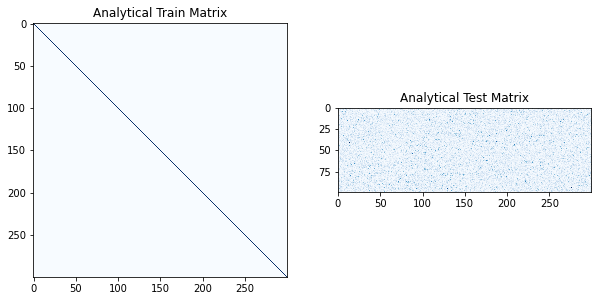

In [4]:
# Compare SVC method with with quantum kernel 
from qiskit.circuit.library import ZZFeatureMap
from qiskit import opflow

# define quantum feature map
circuit_depth=2
my_feature_map = ZZFeatureMap(feature_dimension=feature_dimensions, 
                            reps=circuit_depth)

def calculate_kernel(feature_map, x_data, y_data=None):
    if y_data is None: y_data=x_data 
    x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(x_data).tolist()))
        )
    y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(y_data).tolist()))
        ) 
    kernel = np.abs(
        (~y_circuits.to_matrix_op() @ x_circuits.to_matrix_op()).eval()
    )**2
    return kernel


# compute quantum kernel
t1=time.time()
train_kernel = calculate_kernel(my_feature_map, np.array(train_data))
test_kernel = calculate_kernel(my_feature_map,  np.array(train_data), np.array(test_data))
t2=time.time()
print(f"{int(t2-t1)} seconds for computing train ({len(train_kernel)}) and test ({len(test_kernel)}) sets' kernels .")

# train SVC with quantum kernel
q_model = SVC(kernel='precomputed', random_state=seed, probability=True)
q_model.fit(train_kernel, train_labels)
q_accuracy = q_model.score(test_kernel, test_labels)

print(f"Normalize input feature: {normalizeFeature}\n")
print("Quantum kernel (circuit_depth={}) - Test accuracy = {:<4.1f}%".format(circuit_depth, q_accuracy*100))

# visualize computed kernels
if toViz:
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest',
                  origin='upper', cmap='Blues')
    axs[0].set_title("Analytical Train Matrix")
    axs[1].imshow(np.asmatrix(test_kernel), interpolation='nearest',
                  origin='upper', cmap='Blues')
    axs[1].set_title("Analytical Test Matrix")
    plt.show()

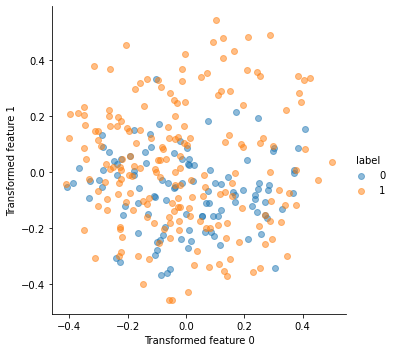

In [5]:
# The input dimension 12 is larger than qubits available on IBMQ backend 

# dimension reduction over original data
from sklearn.decomposition import KernelPCA

if reduced_dimensions< feature_dimensions:
    t1=time.time()
    pca = KernelPCA(n_components=reduced_dimensions, kernel='rbf' )
    data_reduced = pca.fit_transform(np.array(train_data + test_data))
    t2=time.time()
else:
    data_reduced = np.array(train_data + test_data)
    
# Normalize
if normalizeFeature:
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    data_reduced = min_max_scaler.fit_transform(data_reduced)

    
train_data_reduced = data_reduced[:subtrainset]
test_data_reduced = data_reduced[subtrainset:]

if toViz and reduced_dimensions==2:
    import seaborn as sns
    N=len(train_data) if len(train_data)<1000 else 1000
    lbl1 = f'Transformed feature 0'
    lbl2 = f'Transformed feature 1'    
    df = pd.DataFrame({lbl1: [data_reduced[i][0] for i in range(N)], 
                       lbl2: [data_reduced[i][1] for i in range(N)], 
                       'label':train_labels[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})
    
else:
    print('feature_dimensions', feature_dimensions)
    print('reduced_dimensions', reduced_dimensions)

Normalize input feature: False
reduced_dimensions 2 



/tmp/ipykernel_72402/3889941728.py:44: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=FEATURE_MAP,


987 seconds for training VQC
2 qubits | Accuracy : Test 60.0%   Train 58.3%


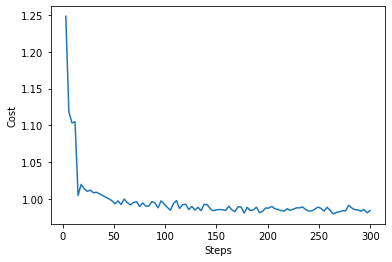

In [6]:
# Compare with QVC method
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.preprocessing import OneHotEncoder
from qiskit import BasicAer
from qiskit.algorithms.optimizers import SPSA


backend_name='qasm_simulator' #'ibmq_lima' 'qasm_simulator' 

# Encoding data and labels
FEATURE_MAP = ZZFeatureMap(feature_dimension=reduced_dimensions, reps=2)
VAR_FORM = TwoLocal(reduced_dimensions,  
                ['ry', 'rz'],# parameterized single qubit rotations 
                'cz',        # entangling gate
                #'full',     # entangle type 
                reps=2,      # layers
                insert_barriers=True
            )

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(np.array(test_labels).reshape(-1, 1)).toarray()

# Setup training monitor log
class Optimizerlog:
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
#        
log = Optimizerlog()    

print(f"Normalize input feature: {normalizeFeature}")
print('reduced_dimensions', reduced_dimensions, '\n')


# Construct VQC object
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          optimizer=SPSA(callback=log.update),
          loss='cross_entropy',
          quantum_instance=BasicAer.get_backend(backend_name), 
         )

t1=time.time()
vqc.fit(np.array(train_data_reduced), np.array(train_labels_oh))
print(f"{int(time.time()-t1)} seconds for training VQC")
    
acc_train = vqc.score(train_data_reduced, train_labels_oh)
acc_test = vqc.score(test_data_reduced, test_labels_oh)
print("{} qubits | Accuracy : Test {:<4.1f}%   Train {:<4.1f}%".format(\
                    reduced_dimensions, acc_test*100, acc_train*100))

# plot loss curve
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show('Train loss curve')

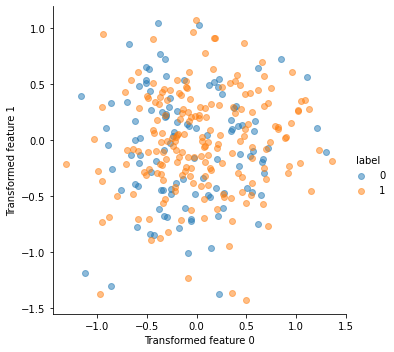

In [7]:
### use dimension reduced data with VAE
import random
reduced_dimensions=2

# load data file
df=pd.read_csv("dataset.egss.z2", header=0)
X=df[["dim-0", "dim-1"]]
y=df["label"]

# take random 80% for training, rest for test.
indice=np.arange(len(y))
split_idx=int(len(indice)*0.8)
random.shuffle(indice)

train_data=[X.iloc[i] for i in indice[:split_idx]]
test_data=[X.iloc[i] for i in indice[split_idx:]]
train_labels=[y.iloc[i] for i in indice[:split_idx]]
test_labels=[y.iloc[i] for i in indice[split_idx:]]

train_data=train_data[:subtrainset]
test_data=test_data[:subtestset]
train_labels=train_labels[:subtrainset]
test_labels=test_labels[:subtestset]

if toViz and reduced_dimensions==2:
    import seaborn as sns
    N=len(train_data) if len(train_data)<1000 else 1000
    lbl1 = f'Transformed feature 0'
    lbl2 = f'Transformed feature 1'    
    df = pd.DataFrame({lbl1: [train_data[i][0] for i in range(N)], 
                       lbl2: [train_data[i][1] for i in range(N)], 
                       'label':train_labels[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})
    
else:
    print('VAE reduced_dimensions', reduced_dimensions)

vae reduced_dimensions 2 

836 seconds for training VQC
2 qubits | Accuracy : Test 52.0%   Train 59.3%


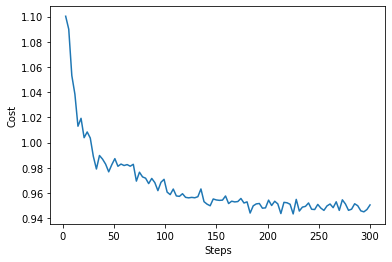

In [8]:
# Compare with QVC method
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.preprocessing import OneHotEncoder
from qiskit import BasicAer
from qiskit.algorithms.optimizers import SPSA


backend_name='qasm_simulator' #'ibmq_lima' 'qasm_simulator' 

# Encoding data and labels
FEATURE_MAP = ZZFeatureMap(feature_dimension=reduced_dimensions, reps=2)
VAR_FORM = TwoLocal(reduced_dimensions,  
                ['ry', 'rz'],# parameterized single qubit rotations 
                'cz',        # entangling gate
                #'full',     # entangle type 
                reps=2,      # layers
                insert_barriers=True
            )

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(np.array(test_labels).reshape(-1, 1)).toarray()

# Setup training monitor log
class Optimizerlog:
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
#        
log = Optimizerlog()    

print('vae reduced_dimensions', reduced_dimensions, '\n')


# Construct VQC object
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          optimizer=SPSA(callback=log.update),
          loss='cross_entropy',
          quantum_instance=BasicAer.get_backend(backend_name), 
         )

t1=time.time()
vqc.fit(np.array(train_data), np.array(train_labels_oh))
print(f"{int(time.time()-t1)} seconds for training VQC")
    
acc_train = vqc.score(train_data, train_labels_oh)
acc_test = vqc.score(test_data, test_labels_oh)
print("{} qubits | Accuracy : Test {:<4.1f}%   Train {:<4.1f}%".format(\
                    reduced_dimensions, acc_test*100, acc_train*100))

# plot loss curve
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show('Train loss curve')

In [9]:
# vae 30 epochs

# z2  Test 57.0%   Train 60.0%
# z4  Test 44.0%   Train 64.3%